In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from db.db_utils import get_engine

In [3]:
# Set visual style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [4]:
#Connect to PostgreSQL
engine = get_engine()

In [5]:
query = """
SELECT *
FROM readmission_cleaned
"""
df = pd.read_sql(query, engine)
df.head()

,Year,Quarter,Period of coverage,Breakdown,Level,Level description,Indicator value,Lower CI,Upper CI,Standardised ratio,Standardised ratio lower CI,Standardised ratio upper CI,Observed,Population,Expected,Percent unclassified,Category
0,2023/24,Annual,1/4/2023 to 31/3/2024,England,England,England,841.8,839.5,844.1,102.6,102.3,102.9,521065.0,57690300,507865.9,NaN,National
1,2022/23,Annual,1/4/2022 to 31/3/2023,England,England,England,780.8,778.6,783.0,95.2,94.9,95.4,476774.0,57106400,500993.5,NaN,National
2,2021/22,Annual,1/4/2021 to 31/3/2022,England,England,England,808.9,806.6,811.2,98.6,98.3,98.9,486173.0,56554900,493128.1,NaN,National
3,2020/21,Annual,1/4/2020 to 31/3/2021,England,England,England,662.2,660.2,664.3,80.7,80.5,81.0,397738.0,56550100,492767.4,NaN,National
4,2019/20,Annual,1/4/2019 to 31/3/2020,England,England,England,862.1,859.8,864.5,105.1,104.8,105.4,512608.0,56287000,487822.8,NaN,National


In [6]:
df['Category'].unique()

array(['National', 'Gender', 'Age', 'Umknown', 'Region', 'Deprivation',
       'Condition'], dtype=object)

### Total Readmissions Over Time

In [7]:
query = """
SELECT "Year", SUM("Indicator value") AS total_readmissions
FROM readmission_cleaned
GROUP BY "Year"
ORDER BY "Year"
"""
df_yearly = pd.read_sql(query, engine)


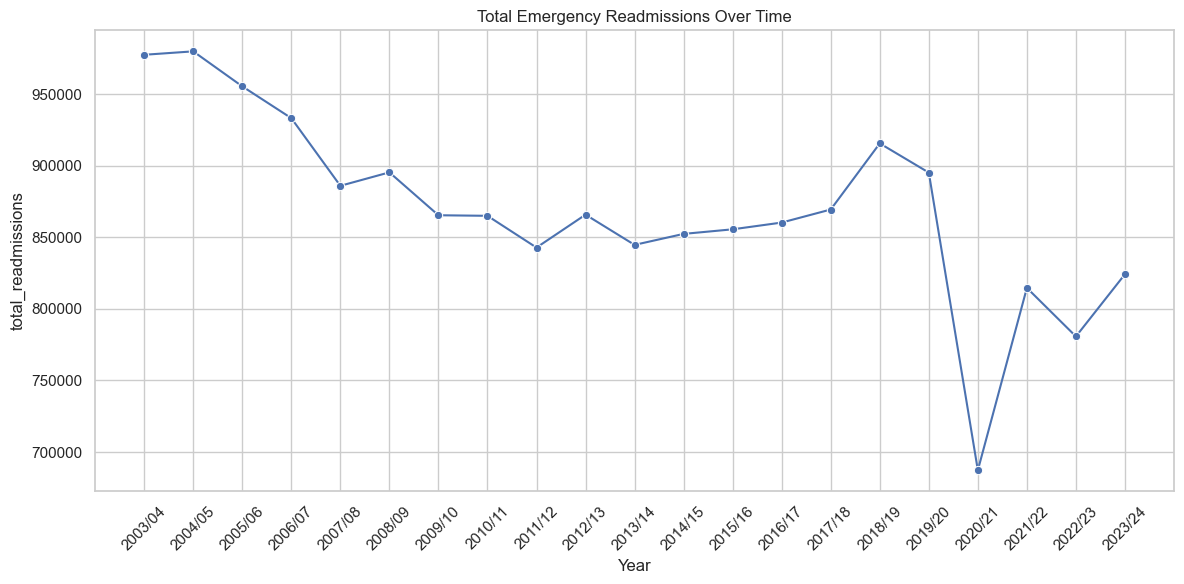

In [8]:

sns.lineplot(data=df_yearly, x='Year', y='total_readmissions', marker='o')
plt.title("Total Emergency Readmissions Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Regions by Total Readmissions

In [9]:
query = """
SELECT "Level description" AS region, SUM("Indicator value") AS total
FROM readmission_cleaned
WHERE "Category" = 'Region'
GROUP BY region
ORDER BY total DESC
LIMIT 10
"""
df_regions = pd.read_sql(query, engine)


/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2183876417.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_regions, x='total', y='region', palette='Blues_d')


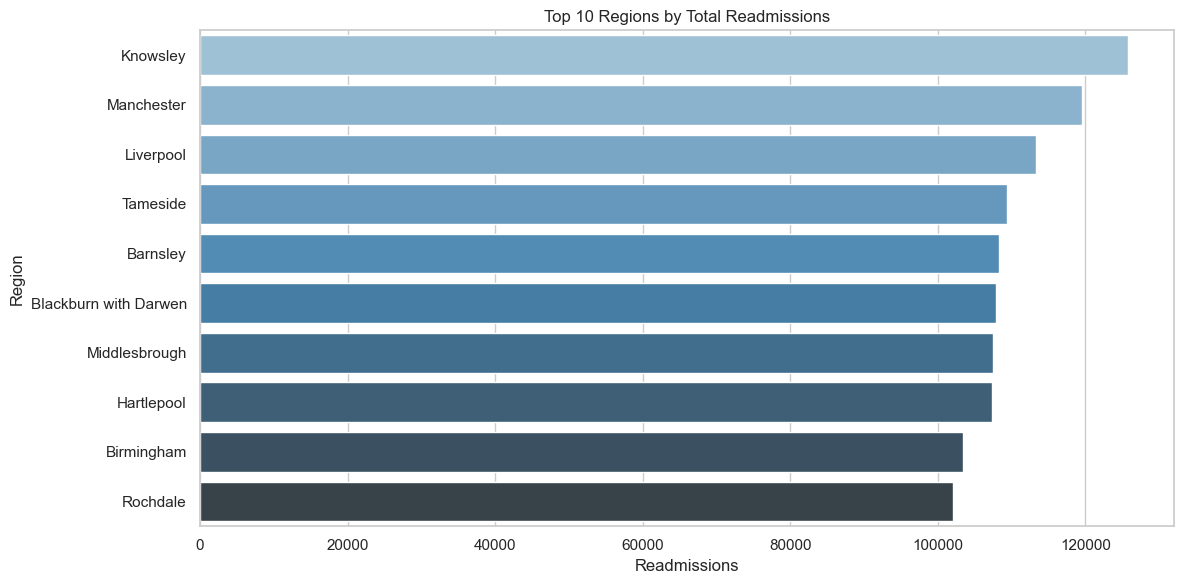

In [10]:
sns.barplot(data=df_regions, x='total', y='region', palette='Blues_d')
plt.title("Top 10 Regions by Total Readmissions")
plt.xlabel("Readmissions")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

###  Readmissions by Age Group Over Time

In [11]:
query = """
SELECT "Year", "Level description" AS age_group, SUM("Indicator value") AS total
FROM readmission_cleaned
WHERE "Category" = 'Age'
GROUP BY "Year", age_group
ORDER BY "Year"
"""
df_age = pd.read_sql(query, engine)

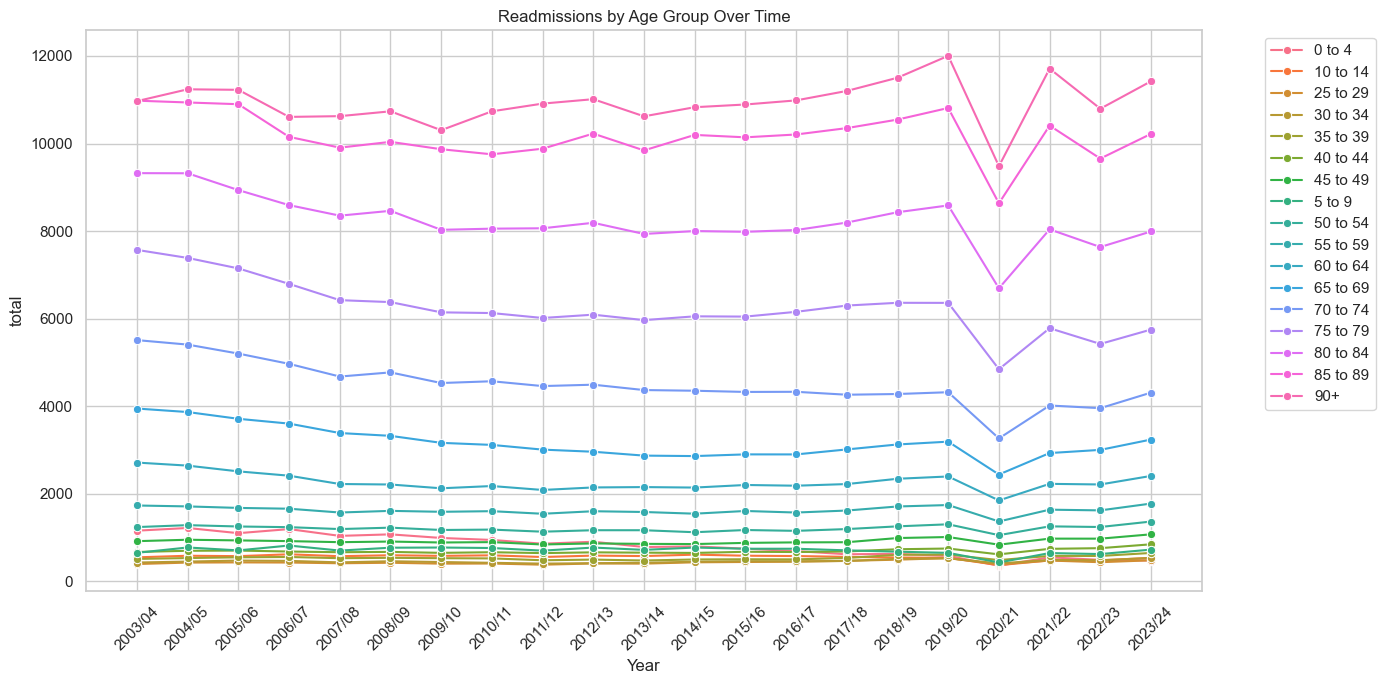

In [12]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_age, x='Year', y='total', hue='age_group', marker='o')
plt.title("Readmissions by Age Group Over Time")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Average Readmission Rate Per Year

In [13]:
query = """
SELECT 
  "Year", 
  ROUND(AVG("Indicator value")::NUMERIC, 2) AS avg_readmission_rate
FROM readmission_cleaned
GROUP BY "Year"
ORDER BY "Year" DESC
"""
df_avg_rate = pd.read_sql(query, engine)

/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2510026833.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_avg_rate, x="Year", y="avg_readmission_rate", palette="mako")


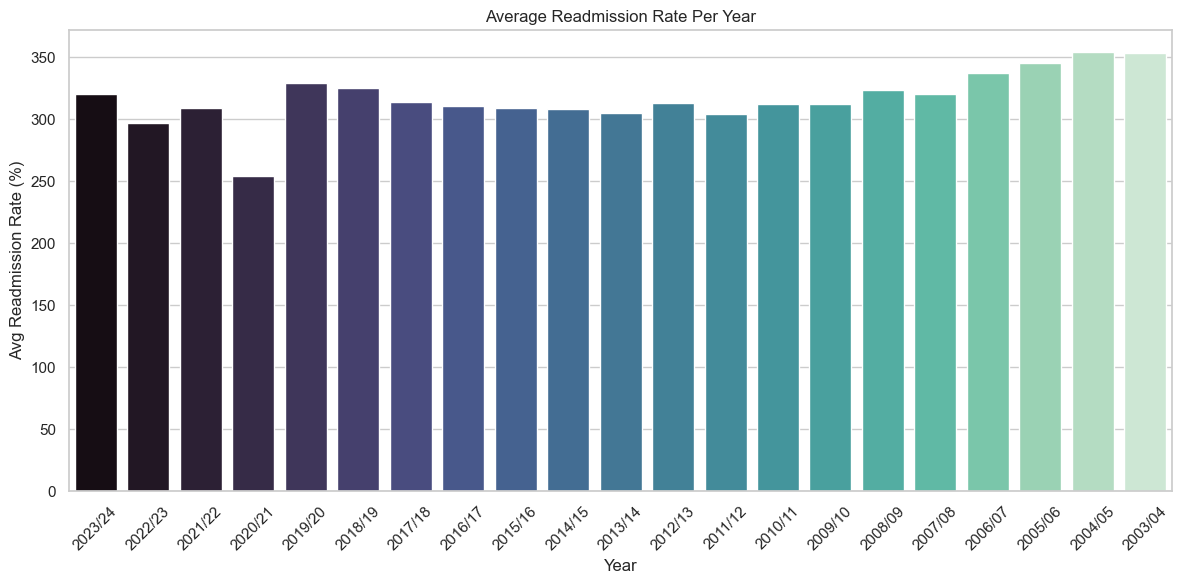

In [14]:
sns.barplot(data=df_avg_rate, x="Year", y="avg_readmission_rate", palette="mako")
plt.title("Average Readmission Rate Per Year")
plt.ylabel("Avg Readmission Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Identify the Year with the Highest Readmissions

In [15]:
query = """
SELECT "Year", SUM("Observed") AS total_readmissions
FROM readmission_cleaned
GROUP BY "Year"
ORDER BY total_readmissions DESC
LIMIT 1
"""
df_peak_year = pd.read_sql(query, engine)
df_peak_year

,Year,total_readmissions
0,2018/19,8943274.0


### Compare Expected vs Observed Readmissions

In [16]:
query = """
SELECT 
  "Year", 
  SUM("Observed") AS total_observed, 
  SUM("Expected") AS total_expected,
  ROUND(((SUM("Observed") - SUM("Expected")) / SUM("Expected"))::NUMERIC * 100, 2) AS deviation_percent
FROM readmission_cleaned
GROUP BY "Year"
ORDER BY "Year" DESC
"""
df_expected_vs_observed = pd.read_sql(query, engine)
df_expected_vs_observed.head()

,Year,total_observed,total_expected,deviation_percent
0,2023/24,7298900.0,7116387.4,2.56
1,2022/23,6677702.0,7019733.3,-4.87
2,2021/22,6812674.0,6911080.6,-1.42
3,2020/21,6363400.0,7887633.3,-19.32
4,2019/20,8204908.0,7808982.6,5.07


### Compare Expected vs Observed by Region

In [17]:
query = """
SELECT 
  "Level description" AS region,
  SUM("Observed") AS total_observed,
  SUM("Expected") AS total_expected,
  ROUND(((SUM("Observed") - SUM("Expected")) / SUM("Expected"))::NUMERIC * 100, 2) AS deviation_percent
FROM readmission_cleaned
WHERE "Category" = 'Region'
GROUP BY region
ORDER BY deviation_percent DESC
"""
df_region_deviation = pd.read_sql(query, engine)
df_region_deviation.head()

,region,total_observed,total_expected,deviation_percent
0,Knowsley,181364.0,100201.2,81.00
1,Manchester,447782.0,258238.6,73.40
2,Liverpool,482362.0,294984.8,63.52
3,Tameside,238210.0,149566.6,59.27
4,Barnsley,264478.0,168126.4,57.31


### Top 10 Regions by Deviation

/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/727639897.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="deviation_percent", y="region", palette="coolwarm")


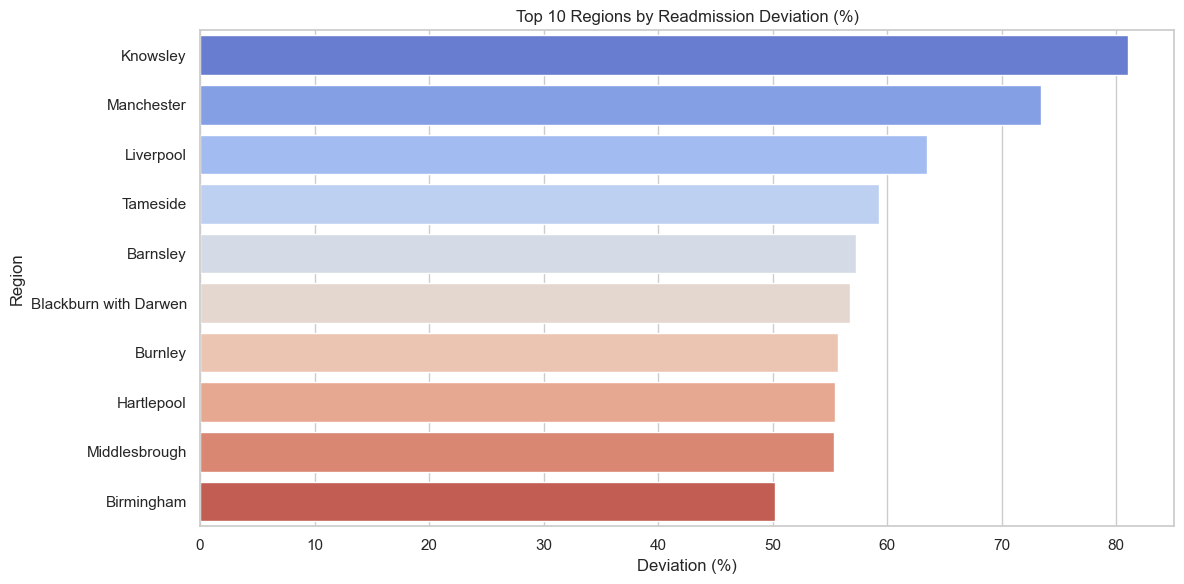

In [18]:
top10 = df_region_deviation.sort_values(by="deviation_percent", ascending=False).head(10)

sns.barplot(data=top10, x="deviation_percent", y="region", palette="coolwarm")
plt.title("Top 10 Regions by Readmission Deviation (%)")
plt.xlabel("Deviation (%)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()

### Compare Expected vs Observed by Region

In [19]:
query = """
SELECT 
  "Level description" AS condition,
  SUM("Observed") AS total_observed,
  SUM("Expected") AS total_expected,
  ROUND(((SUM("Observed") - SUM("Expected")) / SUM("Expected"))::NUMERIC * 100, 2) AS deviation_percent
FROM readmission_cleaned
WHERE "Category" = 'Condition'
GROUP BY condition
ORDER BY deviation_percent DESC
"""
df_condition_dev = pd.read_sql(query, engine)
df_condition_dev.head(10)

,condition,total_observed,total_expected,deviation_percent
0,Hypertensive heart and renal disease with (con...,4066.0,606.0,570.96
1,Essential (primary) hypertension,543202.0,301242.7,80.32
2,Sideropenic dysphagia,218.0,127.7,70.71
3,"Iron deficiency anaemia, unspecified",499962.0,313316.9,59.57
4,Unspecified diabetes mellitus,49654.0,33628.0,47.66
5,Hypertensive heart disease without (congestive...,5612.0,4229.3,32.69
6,Malnutrition-related diabetes mellitus,164.0,134.2,22.21
7,Chronic ischaemic heart disease,178214.0,147254.1,21.02
8,Unspecified chronic bronchitis,5110.0,4255.3,20.09
9,Heart failure,2571660.0,2269104.8,13.33


### Compare Expected vs Observed by Age Group

In [20]:
query = """
SELECT 
  "Level description" AS age_group,
  SUM("Observed") AS total_observed,
  SUM("Expected") AS total_expected,
  ROUND(((SUM("Observed") - SUM("Expected")) / SUM("Expected"))::NUMERIC * 100, 2) AS deviation_percent
FROM readmission_cleaned
WHERE "Category" = 'Age'
GROUP BY age_group
ORDER BY deviation_percent DESC
"""
df_agegroup_dev = pd.read_sql(query, engine)
df_agegroup_dev.head()

,age_group,total_observed,total_expected,deviation_percent
0,30 to 34,350518.0,316623.9,10.70
1,35 to 39,416436.0,384083.9,8.42
2,25 to 29,327246.0,306447.4,6.79
3,65 to 69,1732648.0,1634426.8,6.01
4,45 to 49,702250.0,664839.1,5.63


### Top 10 Conditions by Readmission Deviation

/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2216689635.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_conditions, x="deviation_percent", y="condition", palette="viridis")


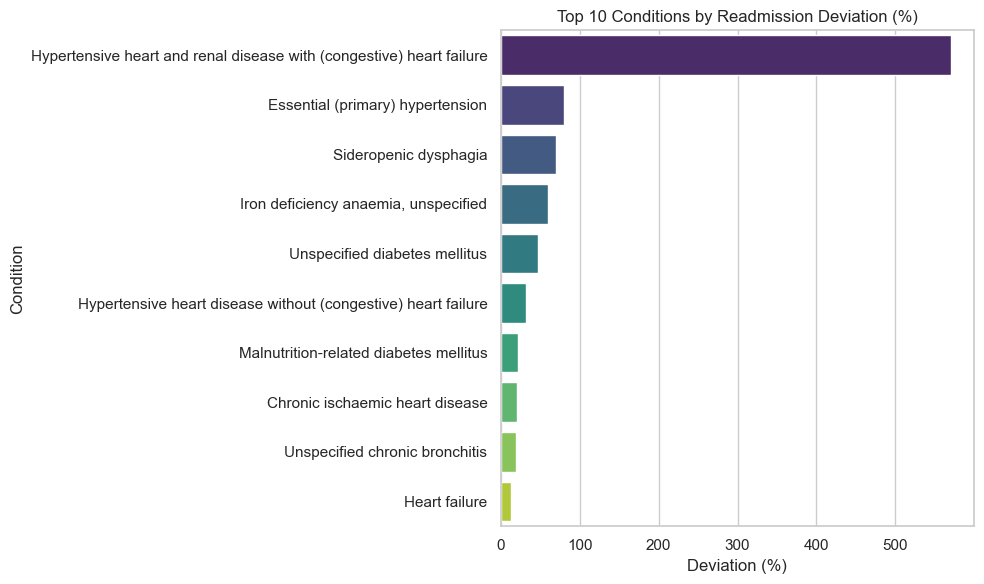

In [21]:
top_conditions = df_condition_dev.sort_values(by="deviation_percent", ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_conditions, x="deviation_percent", y="condition", palette="viridis")
plt.title("Top 10 Conditions by Readmission Deviation (%)")
plt.xlabel("Deviation (%)")
plt.ylabel("Condition")
plt.tight_layout()
plt.show()

###  Age Groups by Readmission Deviation

/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/3417797127.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_agegroup_dev.sort_values(by="deviation_percent", ascending=False),


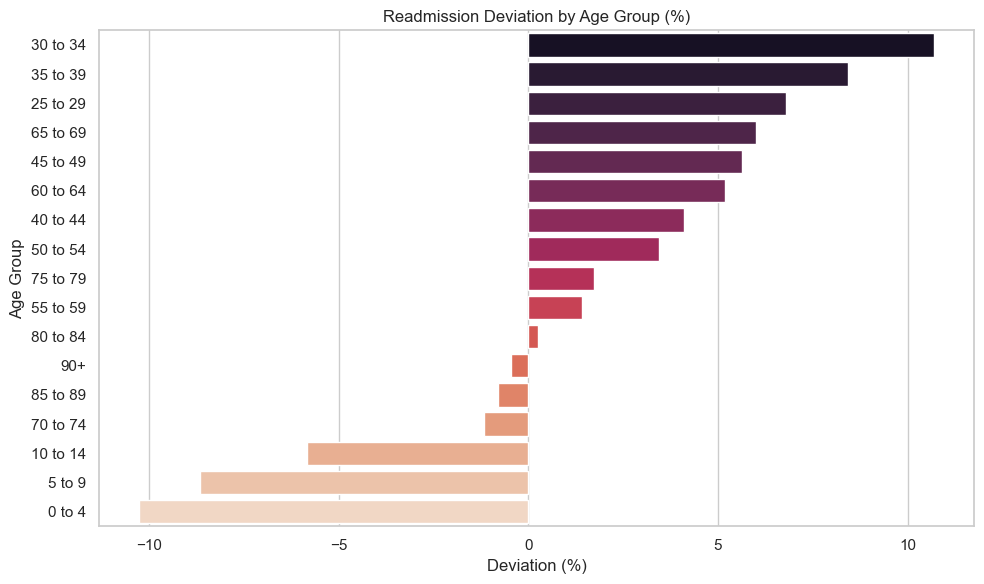

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_agegroup_dev.sort_values(by="deviation_percent", ascending=False), 
            x="deviation_percent", y="age_group", palette="rocket")
plt.title("Readmission Deviation by Age Group (%)")
plt.xlabel("Deviation (%)")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

### Highlight Outlier Conditions by Deviation

In [23]:
# Conditions with deviation over 50% or under -20%
outliers = df_condition_dev[(df_condition_dev["deviation_percent"] > 50) | 
                            (df_condition_dev["deviation_percent"] < -20)]
outliers

,condition,total_observed,total_expected,deviation_percent
0,Hypertensive heart and renal disease with (con...,4066.0,606.0,570.96
1,Essential (primary) hypertension,543202.0,301242.7,80.32
2,Sideropenic dysphagia,218.0,127.7,70.71
3,"Iron deficiency anaemia, unspecified",499962.0,313316.9,59.57
34,Dementia in Alzheimer disease,28960.0,39540.1,-26.76


/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2441497942.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2441497942.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Outlier Type")


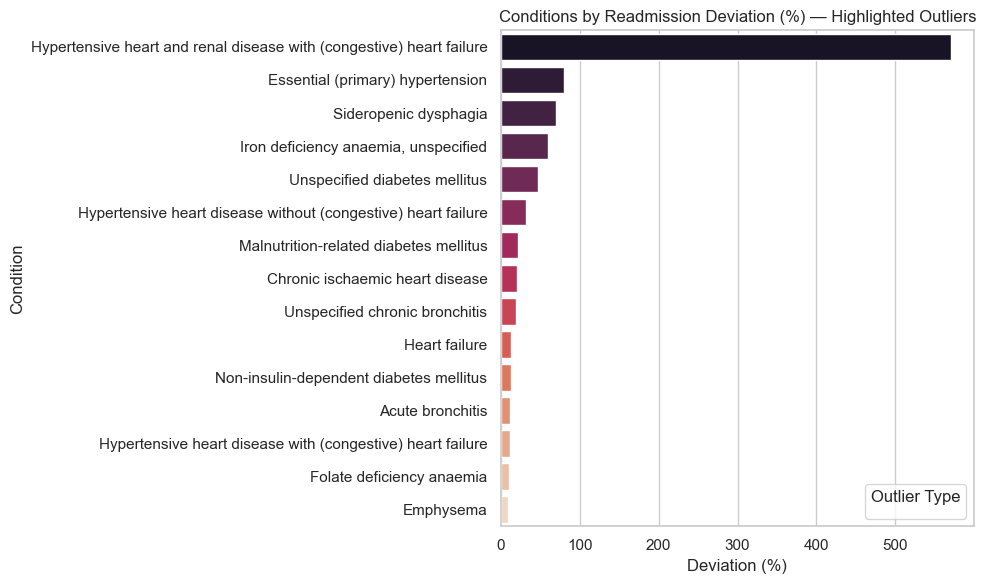

In [24]:
# Plot using hue
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_condition_dev.sort_values(by="deviation_percent", ascending=False).head(15),
    x="deviation_percent",
    y="condition",
    palette="rocket"
)
plt.title("Conditions by Readmission Deviation (%) — Highlighted Outliers")
plt.xlabel("Deviation (%)")
plt.ylabel("Condition")
plt.legend(title="Outlier Type")
plt.tight_layout()
plt.show()


### Highlight Outlier Age Groups by Deviation

/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2849721994.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/c2/lbl69d113l3cxk_srs9x7_cc0000gn/T/ipykernel_49805/2849721994.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Outlier Type")


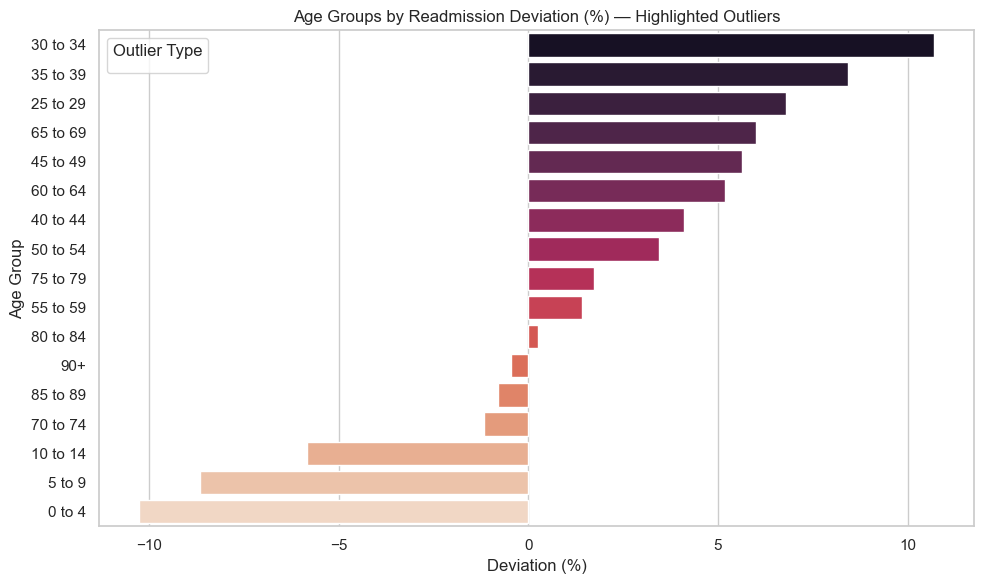

In [26]:
# Plot with custom colors and hue
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_agegroup_dev.sort_values(by="deviation_percent", ascending=False),
    x="deviation_percent",
    y="age_group",
    palette="rocket"
)
plt.title("Age Groups by Readmission Deviation (%) — Highlighted Outliers")
plt.xlabel("Deviation (%)")
plt.ylabel("Age Group")
plt.legend(title="Outlier Type")
plt.tight_layout()
plt.show()